# Аналитика в авиакомпании

Наш проект — это исследование для российской авиакомпании F9, выполняющей внутренние пассажирские авиаперевозки. Нам нужно понять предпочтения пользователей, покупающих билеты на те или иные направления.

На предыдущем этапе мы изучили базу данных и с помощью SQL-запросов получили две таблицы:
- первая содержит информацию о том, сколько рейсов совершили самолеты разных моделей в сентябре 2018 года;
- во второй записано среднее количество рейсов, прибывающих в города за день в августе 2018 года.

Продолжим анализ клиентских предпочтений с этими таблицами.

## Содержание<a name="Содержание"></a>
1. [Изучение общей информации](#изучение_общей_информации)
2. [Анализ данных](#анализ_данных)
  1. [Топ-10 городов по количеству прибывающих рейсов](#топ_10_городов)
  2. [График распределения количества полетов по моделям самолетов](#график_модели_самолетов)
  3. [График распределения среднего количества рейсов по городам](#график_города)
3. [Общий вывод](#вывод)  

## 0. Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## 1. Изучение общей информации <a name="изучение_общей_информации"></a>

Сохраним таблицы в переменные `n_flights_by_model_sept_2018` и `avg_arrivals_by_city_aug_2018`. 

In [2]:
n_flights_by_model_sept_2018 = pd.read_csv('n_flights_by_model_sept_2018.csv')
avg_arrivals_by_city_aug_2018 = pd.read_csv('avg_arrivals_by_city_aug_2018.csv')

Изучим данные: выведем датафреймы и общую информацию о них.

In [3]:
def show_stats(df, title):
    print('\033[1m' + title + '\033[0m')
    display(df)
    print(df.info())
    print(df.describe())

In [4]:
show_stats(df=n_flights_by_model_sept_2018,
           title='Количество полетов по моделям самолетов, сентябрь 2018')

Количество полетов по моделям самолетов, сентябрь 2018


,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes
None
       flights_amount
count        8.000000
mean      2035.625000
std       1965.203947
min        300.000000
25%        605.250000
50%        795.000000
75%       4250.250000
max       4557.000000


In [5]:
show_stats(df=avg_arrivals_by_city_aug_2018,
           title='Среднее количество рейсов, прибывших в город за день, август 2018')

Среднее количество рейсов, прибывших в город за день, август 2018


,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
...,...,...
96,Чита,1.580645
97,Элиста,4.870968
98,Южно-Сахалинск,4.290323
99,Якутск,2.741935


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB
None
       average_flights
count       101.000000
mean          5.494189
std          13.119790
min           1.000000
25%           2.000000
50%           3.000000
75%           5.870968
max         129.774194


Изучив информацию выше, можно сказать, что с данными все хорошо:
* названия столбцов понятные и правильно записаны, 
* в таблицах нет пропусков,
* нет и аномальных значений (130 полетов в день приходятся на Москву — это нормально),
* у столбцов правильные типы данных.

### Поиск дубликатов

Осталось проверить таблицы на наличие дубликатов. В таблице с моделями самолетов на глаз видно, что дубликатов нет. А вот датафрейм со среднесуточным количество рейстов придется проверить по следующей схеме:
1. Сохраним столбец `city` в переменную `city`.
2. Приведем этот столбецй в датафрейме к нижнему регистру.
3. Заменим все «ё» на «е».
4. Проверим, есть ли в преобразованном датафрейме дубликаты. Если есть, удалим строчки с ними.
5. Присвоим столбцу `city` значение переменной `city` обратно.
6. Сбросим индексы датафрейма, если окажется, что в нем были дубликаты.

Пункты 2 и 3 нужны, чтобы исключить ошибки ввода. А 1 и 5 — чтобы имена собственные оставались опрятными с заглавными буквами 🙂

In [6]:
#1 
city = avg_arrivals_by_city_aug_2018['city'].copy()

#2
avg_arrivals_by_city_aug_2018['city'] = avg_arrivals_by_city_aug_2018['city'].str.lower()

#3
def fix_yo(string):
    fixed_name = ''
    
    for symbol in string:
        if symbol == 'ё':
            fixed_name += 'е'   
        else:
            fixed_name += symbol
    return fixed_name
    
avg_arrivals_by_city_aug_2018['city'] = avg_arrivals_by_city_aug_2018['city'].apply(fix_yo)

#4
print('Число дубликатов в таблице со среднесуточным количеством рейсов:', avg_arrivals_by_city_aug_2018.duplicated().sum())

Число дубликатов в таблице со среднесуточным количеством рейсов: 0


Оказалось, что в таблицу со среднесуточным числом рейсов дубликатов тоже нет.

In [7]:
avg_arrivals_by_city_aug_2018['city'] = city

### Вывод

Мы изучили и данные и проверили их на наличие ошибок. Оказалось, что проблем нет:
* названия столбцов понятные и правильно записаны, 
* в таблицах нет пропусков,
* нет и аномальных значений (130 полетов в день приходятся на Москву — это нормально),
* нет дубликатов,
* у столбцов правильные типы данных.

[К содержанию](#Содержание)

## 2. Анализ данных <a name="анализ_данных"></a>

### Топ-10 городов по количеству прибывающих рейсов <a name="топ_10_городов"></a>

Сохраним топ-10 городов по количеству рейсов в переменную `top_10_cities_by_avg_flights`. Сразу проверим, что получилось.

In [8]:
top_10_cities_by_avg_flights = (avg_arrivals_by_city_aug_2018
                                                        .sort_values(by='average_flights', ascending=False)
                                                        .head(10))
top_10_cities_by_avg_flights

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


### График распределения количества полетов по моделям самолетов <a name="график_модели_самолетов"></a>

Начнем изучение графиков с построения распределения рейсов по моделям самолетов.

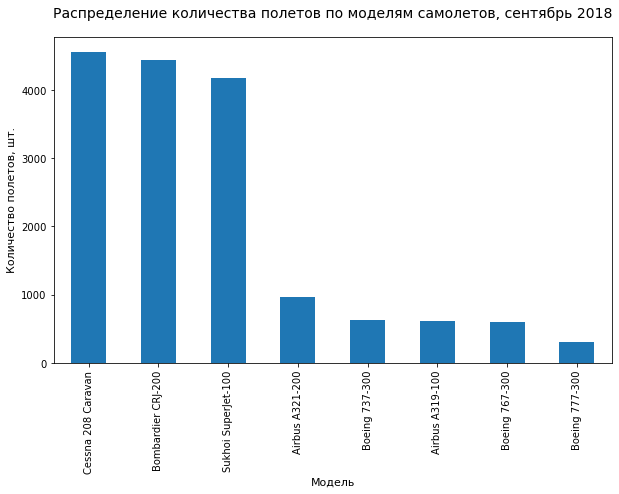

In [9]:
(n_flights_by_model_sept_2018
     .sort_values(by='flights_amount', ascending=False)
     .plot(x='model', y='flights_amount', kind='bar', legend=False, figsize=(10, 6)))

plt.title('Распределение количества полетов по моделям самолетов, сентябрь 2018', fontsize=14, y=1.04)
plt.xlabel('Модель', fontsize=11)
plt.ylabel('Количество полетов, шт.', fontsize=11)

flight_per_model_graph = plt.gcf()

Модели можно поделить на две группы: в первой у самолета около 4 тысяч полетов, во второй — меньше тысячи. Я думаю, это объясняется вместимостью самолетов. Вот данные о ней (количество мест указано с учетом пилотов и персонала):

* Cessna 208 Caravan — 14 мест
* Bombardier CRJ-200 — 100 мест
* Sukhoi Superjet 100 — 103 места


* Airbus A321-200 — 220 мест
* Boeing 737-300 — 149 мест
* Airbus A319-100 — 144 места
* Boeing 767-300 — 375 мест
* Boeing 777-300 — 550 мест

Видно, что самолеты из первой группы могут перевозить до ста пассажиров, а из второй — от 140 и даже от 350 человек. Маленькие самолеты чаще летают, потому что быстрее заполняются, а также они подходят для бОльшего числа направлений. Вместительным самолетам выгодно летать между крупными городами, а маленькие могут совершать рейсы и между небольшими населенными пунктами.

### График распределения среднего количества рейсов по городам <a name="график_города"></a>

Теперь посмотрим, как распределяется среднее количество рейсов по городам.

Text(0, 0.5, 'Среднее количество рейсов в день, шт.')

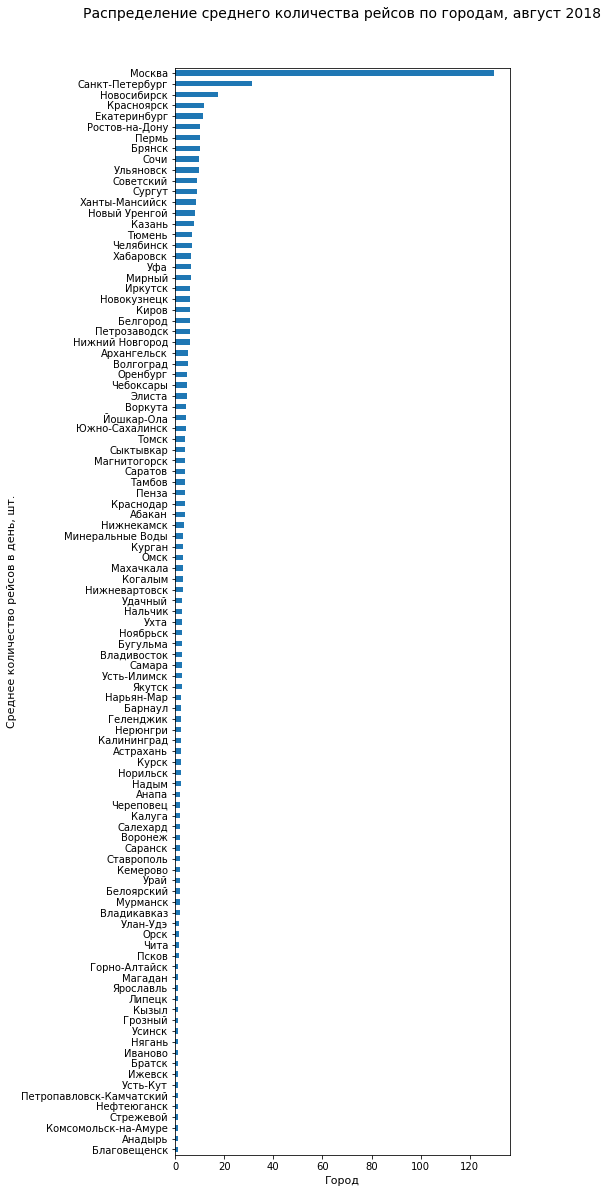

In [10]:
(avg_arrivals_by_city_aug_2018
     .sort_values(by='average_flights', ascending=True)
     .plot(x='city', y='average_flights', kind='barh', legend=False, figsize=(6, 20)))

plt.title('Распределение среднего количества рейсов по городам, август 2018', fontsize=14, y=1.04)
plt.xlabel('Город', fontsize=11)
plt.ylabel('Среднее количество рейсов в день, шт.', fontsize=11)

Из-за большого числа городов графиком неудобно пользоваться. Посмотрим на аналогичное распределение только для топ-10 городов по среднему количеству рейсов. Тем более с четвертого города значения примерно одинаковые и плавно идут на спад.

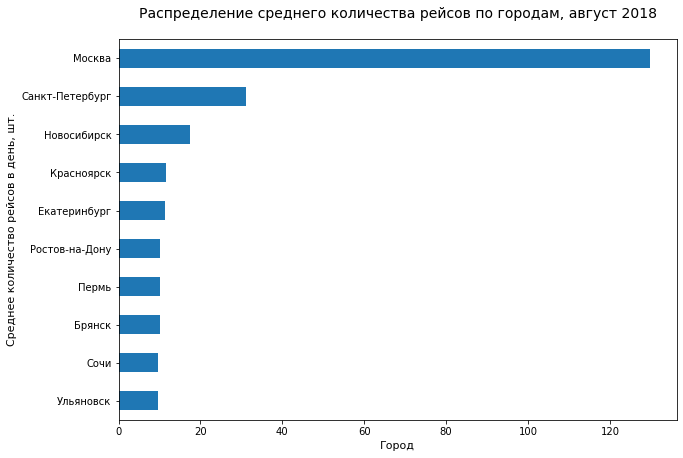

In [11]:
(top_10_cities_by_avg_flights
     .sort_values(by='average_flights', ascending=True)
     .plot(x='city', y='average_flights', kind='barh', legend=False, figsize=(10, 7)))

plt.title('Распределение среднего количества рейсов по городам, август 2018', fontsize=14, y=1.04)
plt.xlabel('Город', fontsize=11)
plt.ylabel('Среднее количество рейсов в день, шт.', fontsize=11)

top_10_cities_graph = plt.gcf()

На первом месте по количеству принятых за день рейсов ожидаемо оказалась Москва. Причем с четырехкратным отрывом от Санкт-Петербурга, который находится на втором месте с 30 рейсами в день. Места с 3 по 7 занимают города миллионники. Среди них выделяется третий по числу населения город России Новосибирск, у которого среднее число принятых рейсов чуть больше 17. У остальных городов этот показатель примерно равен 10.

[К содержанию](#Содержание)

## 3. Общий вывод <a name="вывод"></a>

Целью нашего исследования было понять предпочтения пользователей, покупающих билеты на те или иные направления.

Оказалось, что самые популярные направления — города миллионики. Скорее всего, числом населения популярность и объяснятся.

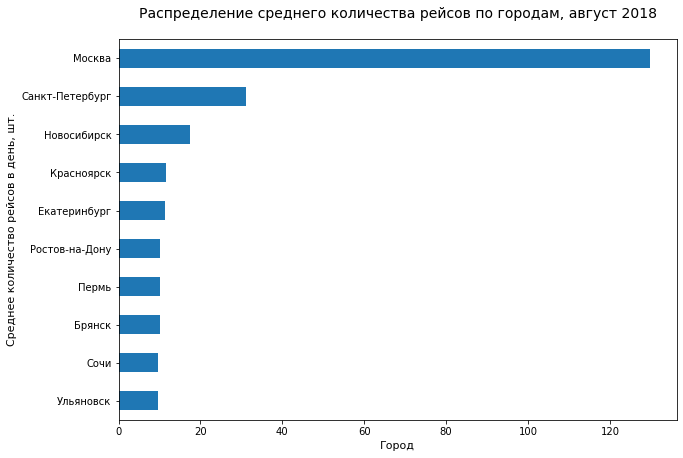

In [12]:
top_10_cities_graph

Также мы выяснили, что небольшие самолеты вместимостью до 100 пассажиров совершают примерно в 4 раза больше рейсов, чем крупные лайнеры.

**Вместительность самолетов**

* Cessna 208 Caravan — 14 мест
* Bombardier CRJ-200 — 100 мест
* Sukhoi Superjet 100 — 103 места


* Airbus A321-200 — 220 мест
* Boeing 737-300 — 149 мест
* Airbus A319-100 — 144 места
* Boeing 767-300 — 375 мест
* Boeing 777-300 — 550 мест

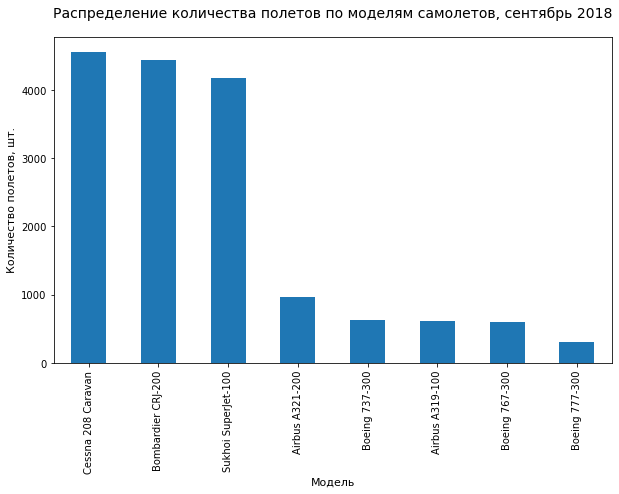

In [13]:
flight_per_model_graph

[К содержанию](#Содержание)